# Homework 2

In [0]:
!pip install -q pydot 
!apt-get install graphviz
!pip install -q boto3

In [0]:
from keras.models import  Sequential, Model, model_from_json, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import regularizers
from keras import backend as K
from keras.preprocessing import sequence
import tensorflow as tf
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Dropout, Activation, Lambda,Flatten, Reshape
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers import Input, ELU, LSTM, Embedding, Convolution2D, MaxPooling2D, \
BatchNormalization, Convolution1D, MaxPooling1D, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from PIL import Image
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional, SimpleRNN

import pandas as pd
import numpy as np
import boto3
import re, os
from string import printable
import pydot

from pathlib import Path
import json

import warnings
warnings.filterwarnings("ignore")

from tensorflow.python.client import device_lib

from keras.utils import plot_model # pydot, graphviz are dependencies
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint


# -Plot libs-
import matplotlib.pyplot as plt
from IPython.display import SVG, display

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Autoencoder

First, I loaded the mnist fashion dataset.

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


An example of these pictures is as below.

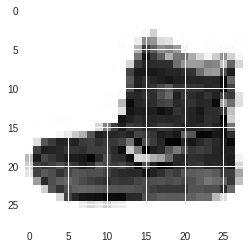

In [0]:
plt.imshow(x_train[0])

Reshape the dataset.

In [0]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

Build the auto-encoder.

In [0]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 184us/step - loss: 0.3684 - val_loss: 0.3299
Epoch 2/50
60000/60000 [==============================] - 8s 138us/step - loss: 0.3201 - val_loss: 0.3120
Epoch 3/50
60000/60000 [==============================] - 8s 133us/step - loss: 0.3116 - val_loss: 0.3173
Epoch 4/50
60000/60000 [==============================] - 8s 132us/step - loss: 0.3070 - val_loss: 0.3073
Epoch 5/50
60000/60000 [==============================] - 8s 134us/step - loss: 0.3041 - val_loss: 0.3086
Epoch 6/50
60000/60000 [==============================] - 8s 134us/step - loss: 0.3020 - val_loss: 0.3044
Epoch 7/50
60000/60000 [==============================] - 9s 145us/step - loss: 0.3003 - val_loss: 0.3014
Epoch 8/50
60000/60000 [==============================] - 9s 146us/step - loss: 0.2990 - val_loss: 0.2977
Epoch 9/50
60000/60000 [==============================] - 9s 146us/step - loss: 0.2975 - val_loss: 0.

Now, we can use the autoencoders to present the decoded reconstruction of each fashion item. I think this method is more potent than PCA.

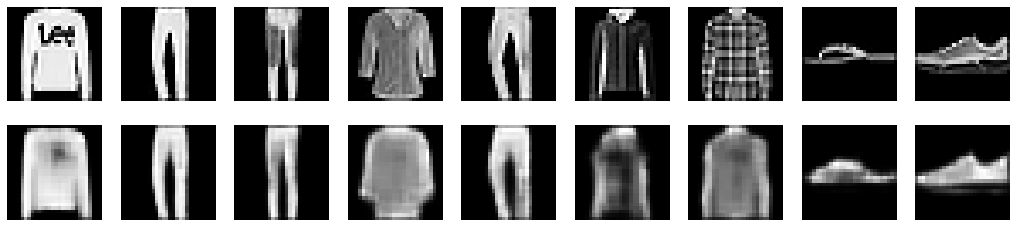

In [0]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2. Image Classification

### 2.1 Deep CNN

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [0]:
x_train = x_train.reshape(x_train.shape[0], 28, 28,1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28,1).astype('float32') / 255

We need to convert the target response to numerical categories to train our model

In [0]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

Use LeNet Architecture to do the image classification.

In [0]:
# =============================
#  Setting up LeNet Architecture
# ============================
model = Sequential()

model.add(Conv2D(filters = 32,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 32,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 32,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid', input_shape=(28,28,1)))

model.add(Flatten())
model.add(Dense(84))
model.add(Dense(10))
model.add(Activation('softmax'))

In [54]:
l_rate = 1
sgd = SGD(lr=l_rate, momentum=0.0, decay=0.0, nesterov=False)
# model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy']) -takes a long time to converge
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10,
          verbose=2, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 56s - loss: 0.6051 - acc: 0.7763 - val_loss: 0.4097 - val_acc: 0.8487
Epoch 2/10
 - 54s - loss: 0.4133 - acc: 0.8477 - val_loss: 0.3453 - val_acc: 0.8747
Epoch 3/10
 - 54s - loss: 0.3679 - acc: 0.8654 - val_loss: 0.3168 - val_acc: 0.8869
Epoch 4/10
 - 53s - loss: 0.3457 - acc: 0.8726 - val_loss: 0.3174 - val_acc: 0.8833
Epoch 5/10
 - 53s - loss: 0.3283 - acc: 0.8806 - val_loss: 0.3135 - val_acc: 0.8862
Epoch 6/10
 - 54s - loss: 0.3159 - acc: 0.8828 - val_loss: 0.2830 - val_acc: 0.8960
Epoch 7/10
 - 54s - loss: 0.3072 - acc: 0.8857 - val_loss: 0.2820 - val_acc: 0.8975
Epoch 8/10
 - 53s - loss: 0.3029 - acc: 0.8884 - val_loss: 0.2949 - val_acc: 0.8924
Epoch 9/10
 - 53s - loss: 0.2939 - acc: 0.8906 - val_loss: 0.2746 - val_acc: 0.8988
Epoch 10/10
 - 53s - loss: 0.2885 - acc: 0.8924 - val_loss: 0.2795 - val_acc: 0.8952


In [55]:
print("Testing accuracy = %0.05f" % model.evaluate(x_test, y_test)[1])

10000/10000 [==============================] - 3s 306us/step
Testing accuracy = 0.89520


In [56]:
print("Training accuracy = %0.05f" % model.evaluate(x_train, y_train)[1])

60000/60000 [==============================] - 19s 311us/step
Training accuracy = 0.91215


The performance of this model is sound. The test accuracy is close to the training accuracy. Hence, I do not think the problem of overfitting exists in this case.

### 2.2 Transfer Learning

In this section, I used the VGG to do the transfer learning. Notice that the VGG requires an input of three channels and 48*48 pixels. Hence, I reshape the dataset to (length, 48, 48, 3)

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [79]:
x_train= np.reshape(x_train, (len(x_train), 28*28))
x_train = np.dstack([x_train] * 3)
x_test= np.reshape(x_test, (len(x_test), 28*28))
x_test = np.dstack([x_test] * 3)
x_train = x_train.reshape(-1, 28,28,3)
x_test= x_test.reshape (-1,28,28,3)
x_train.shape,x_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [80]:
# Reshape image to (48,48)
from keras.preprocessing.image import img_to_array, array_to_img
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])
x_train.shape, x_test.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [0]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

Build the transfer learning model. Notice that we only train the last layer. Hence, we set the layer.trainable parameter to false.

In [0]:
number_of_classes = 10

vgg = VGG16(weights = "imagenet", include_top=False,  input_shape=(48, 48, 3) ,pooling='max', classes=number_of_classes)


for layer in vgg.layers[:17]:
    layer.trainable = False

x = vgg.output
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(number_of_classes, activation="softmax")(x)

# creating the final model 
vgg_model = Model(inputs = vgg.input, outputs = predictions)

In [69]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [72]:
# Training the model
batch_size = 150
epochs = 5
#model = create_model()
vgg_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = vgg_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1896s 32ms/step - loss: 0.4489 - acc: 0.8383 - val_loss: 0.3410 - val_acc: 0.8801
Epoch 2/5
60000/60000 [==============================] - 1901s 32ms/step - loss: 0.3182 - acc: 0.8853 - val_loss: 0.3386 - val_acc: 0.8769
Epoch 3/5
60000/60000 [==============================] - 1891s 32ms/step - loss: 0.2858 - acc: 0.8954 - val_loss: 0.3003 - val_acc: 0.8917
Epoch 4/5
60000/60000 [==============================] - 1896s 32ms/step - loss: 0.2667 - acc: 0.9030 - val_loss: 0.2997 - val_acc: 0.8881
Epoch 5/5
60000/60000 [==============================] - 1890s 31ms/step - loss: 0.2486 - acc: 0.9085 - val_loss: 0.2969 - val_acc: 0.8980


In [82]:
print("Training accuracy = %0.05f" % vgg_model.evaluate(x_train, y_train)[1])
print("Testing accuracy = %0.05f" % vgg_model.evaluate(x_test, y_test)[1])

60000/60000 [==============================] - 1557s 26ms/step
Training accuracy = 0.91668
10000/10000 [==============================] - 259s 26ms/step
Testing accuracy = 0.89800


In [0]:
vgg_model.save('my_vgg_model.h5') 

In this case, the performance of transfer learning is a little bit higher than the deep CNN. However, it takes me a lot of time to train the model.

## 3. Text Classification

In [0]:
benign = pd.read_csv("https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt" , header = None)
malicious =  pd.read_csv("https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt", header = None)

### 3.1 Bidirectional RNN

First, I built a data frame to store all the URLs and their categories.

In [0]:
benign = benign.drop([0])
malicious = malicious.rename(columns = {0:"URL"})
benign = benign.rename(columns = {0:"URL"})
benign['Is_Malicious'] = 0
malicious['Is_Malicious'] = 1

In [0]:
df = pd.concat([benign, malicious])

In [87]:
df.head()

,URL,Is_Malicious
1,.0.blogger.gmodules.com,0
2,.0.client-channel.google.com,0
3,.0.docs.google.com,0
4,.0.drive.google.com,0
5,.0.gvt0.cn,0


I built tokens due to the printable characters. Then, I applied padding to each URL. 

In [88]:
# Data preprocessing

# Convert The URLs to indices of printable characters
url_tokens = [[printable.index(x) + 1 for x in url if x in printable] for url in df.URL]

# maximal lenghth and padding
max_len=75
X = sequence.pad_sequences(url_tokens, maxlen=max_len)
 
# get the response
y = np.array(df.Is_Malicious)

print('Matrix dimensions of X: ', X.shape, 'Vector dimension of response: ', y.shape)

Matrix dimensions of X:  (67352, 75) Vector dimension of response:  (67352,)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In this case, I used the Bidirectional RNN to do the classification.

In [91]:
# Input
max_len=75
emb_dim=32
max_vocab_len=100
output_size=32
W_reg=regularizers.l2(1e-4)

inp = Input(shape=(max_len,),dtype='int32')

x = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len, W_regularizer=W_reg)(inp) 
x = Bidirectional(SimpleRNN(100, 
                             return_sequences=False, 
                             dropout=0.1, 
                             recurrent_dropout=0.1))(x)
x = Dense(1, activation='sigmoid')(x)

# Setting the model
model1 = Model(inputs=inp, outputs=x)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 75, 32)            3200      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               26600     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 201       
Total params: 30,001
Trainable params: 30,001
Non-trainable params: 0
_________________________________________________________________


In [111]:
cwd = os.getcwd()
epochs = 20
batch_size = 32

# early stopping
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='Best_BI_RNN_model.h5', monitor='val_loss', save_best_only=True)]


history1 = model1.fit(X_train, y_train, epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(X_test, y_test),
                     callbacks=callbacks)

loss, accuracy = model1.evaluate(X_train, y_train, verbose=1)
print('\nTraining Accuracy = ', accuracy, '\n')

loss, accuracy = model1.evaluate(X_test, y_test, verbose=1)
print('\nTesting Accuracy =', accuracy, '\n')


Train on 50514 samples, validate on 16838 samples
Epoch 1/20
50514/50514 [==============================] - 73s 1ms/step - loss: 0.0250 - acc: 0.9886 - val_loss: 0.0225 - val_acc: 0.9888
Epoch 2/20
50514/50514 [==============================] - 73s 1ms/step - loss: 0.0245 - acc: 0.9890 - val_loss: 0.0223 - val_acc: 0.9890
Epoch 3/20
50514/50514 [==============================] - 73s 1ms/step - loss: 0.0244 - acc: 0.9888 - val_loss: 0.0220 - val_acc: 0.9889
Epoch 4/20
50514/50514 [==============================] - 73s 1ms/step - loss: 0.0250 - acc: 0.9888 - val_loss: 0.0219 - val_acc: 0.9890
Epoch 5/20
50514/50514 [==============================] - 74s 1ms/step - loss: 0.0246 - acc: 0.9887 - val_loss: 0.0218 - val_acc: 0.9893
Epoch 6/20
50514/50514 [==============================] - 73s 1ms/step - loss: 0.0242 - acc: 0.9888 - val_loss: 0.0218 - val_acc: 0.9897
Epoch 7/20
50514/50514 [==============================] - 73s 1ms/step - loss: 0.0239 - acc: 0.9891 - val_loss: 0.0214 - val_acc

In [0]:
## Using Different URLs to test the model
test_url_mal = ".btscene2.com"
test_url_benign = "www.yahoo.com"

In [0]:
def test_url(url, model):
  # Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer 
  url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable]]

  # Step 2: Cut URL string at max_len or pad with zeros if shorter
  max_len=75
  X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)
  proba = model.predict(X, batch_size=1)
  if proba > 0.5:
        result = "malicious"
  else:
        result = "benign"
  print("Test URL:", url, "is",result)

In [114]:
test_url(test_url_mal,model1)
test_url(test_url_benign,model1)

Test URL: .btscene2.com is malicious
Test URL: www.yahoo.com is benign


The training and testing accuracies are very high, which shows that our model can efficiently detect most malicious URLs.

### 3.2 CNN + LSTM

In [118]:
# Input
max_len=75
emb_dim=32
max_vocab_len=100
output_size=32
W_reg=regularizers.l2(1e-4)

inp = Input(shape=(max_len,),dtype='int32')

x = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len, W_regularizer=W_reg)(inp) 

# CNN
x =Convolution1D(kernel_size=5, filters=256, border_mode='same')(x)
x = ELU()(x)
x = MaxPooling1D(pool_size=4)(x)
x = Dropout(0.1)(x)

# LSTM
x = LSTM(output_size)(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)

# Setting the model
model2 = Model(inputs=inp, outputs=x)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 75, 32)            3200      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 75, 256)           41216     
_________________________________________________________________
elu_3 (ELU)                  (None, 75, 256)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 18, 256)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 18, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                36992     
__________

In [119]:
cwd = os.getcwd()
epochs = 20
batch_size = 32

# early stopping
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='Best_CNN_LSTM_model.h5', monitor='val_loss', save_best_only=True)]


history2 = model2.fit(X_train, y_train, epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(X_test, y_test),
                     callbacks=callbacks)
  

loss, accuracy = model2.evaluate(X_train, y_train, verbose=1)
print('\nTraining Accuracy = ', accuracy, '\n')

loss, accuracy = model2.evaluate(X_test, y_test, verbose=1)
print('\nTesting Accuracy =', accuracy, '\n')

Train on 50514 samples, validate on 16838 samples
Epoch 1/20
50514/50514 [==============================] - 87s 2ms/step - loss: 0.1104 - acc: 0.9796 - val_loss: 0.0670 - val_acc: 0.9813
Epoch 2/20
50514/50514 [==============================] - 85s 2ms/step - loss: 0.0522 - acc: 0.9811 - val_loss: 0.0337 - val_acc: 0.9840
Epoch 3/20
50514/50514 [==============================] - 85s 2ms/step - loss: 0.0286 - acc: 0.9869 - val_loss: 0.0237 - val_acc: 0.9888
Epoch 4/20
50514/50514 [==============================] - 84s 2ms/step - loss: 0.0233 - acc: 0.9892 - val_loss: 0.0214 - val_acc: 0.9901
Epoch 5/20
50514/50514 [==============================] - 84s 2ms/step - loss: 0.0215 - acc: 0.9899 - val_loss: 0.0209 - val_acc: 0.9898
Epoch 6/20
50514/50514 [==============================] - 85s 2ms/step - loss: 0.0202 - acc: 0.9904 - val_loss: 0.0200 - val_acc: 0.9912
Epoch 7/20
50514/50514 [==============================] - 84s 2ms/step - loss: 0.0194 - acc: 0.9912 - val_loss: 0.0192 - val_acc

In [120]:
test_url(test_url_mal,model2)
test_url(test_url_benign,model2)

Test URL: .btscene2.com is malicious
Test URL: www.yahoo.com is benign


The CNN+LSTM model's accuracy is higher than the previous one.

### Comparison

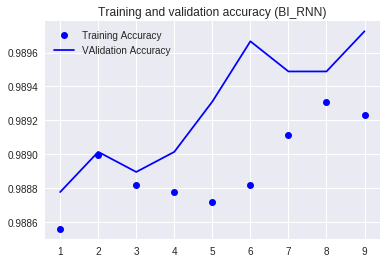

In [115]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Plotting the data 

# Training + Valdiation Accuracy
epochs = range(1,len(acc) + 1)
plt.plot( epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot( epochs, val_acc, 'b', label = 'VAlidation Accuracy')
plt.title('Training and validation accuracy (BI_RNN)')
plt.legend()
plt.figure()

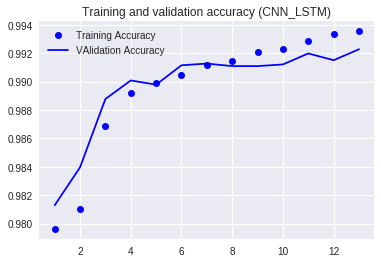

In [122]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Plotting the data 

# Training + Valdiation Accuracy
epochs = range(1,len(acc) + 1)
plt.plot( epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot( epochs, val_acc, 'b', label = 'VAlidation Accuracy')
plt.title('Training and validation accuracy (CNN_LSTM)')
plt.legend()
plt.figure()

From these graphs, we can show that the overall performance of CNN_LSTM is better than the BI_RNN. Moreover, the decrease in loss is more stable for CNN_LSTM. However, it takes more epochs to coverage.

## Reference

1. Chollet, F. (2017).* Deep learning with python.* Manning Publications Co..
2. Melissa K. (2017). *Featureless Deep Learning for Detection of Malicious URLs. *https://github.com/incertum/cyber-matrix-ai/tree/master/Malicious-URL-Detection-Deep-Learning